In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim


In [ ]:
transform = transforms.ToTensor() #definindo a conversao de imagem para tensor
trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

valset = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)


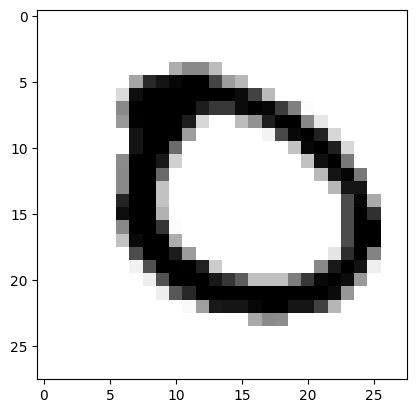

In [ ]:
dataiter = iter(trainloader)
imagens, etiquetas = next(dataiter)
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r');

In [ ]:
print(imagens[0].shape) #verificar as dimensoes do tensor de cada imagem
print(etiquetas[0].shape) #verificar as dimensoes do tensor de cada etiqueta

torch.Size([1, 28, 28])
torch.Size([])


In [ ]:
class Modelo(nn.Module):
  def __init__(self):
    super(Modelo, self).__init__()
    self.linear1 = nn.Linear(28*28, 128) #camada de entrada, 784 neuronios que se ligam a 128
    self.linear2 = nn.Linear(128, 64) #camada interna 1, 128 neuronios que se ligam a 64
    self.linear3 = nn.Linear(64, 10) #camada interna 2, 64 neuronios que se ligam a 10

  def forward(self, X):
    X = F.relu(self.linear1(X)) #funcao de ativacao da camada de entrada para a camada interna 1
    X = F.relu(self.linear2(X)) #funcao de ativacao da camada de entrada para a camada interna 2
    X = self.linear3(X) #funcao de ativacao da camada interna 2 para a camada de saida f(x) = x
    return F.log_softmax(X, dim=1) #dados utilizados para calcular a perda

In [ ]:
def treino(modelo, trainloader, device):
  otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5)
  inicio = time() #time para saber quanto tempo levou para treinar
  criterio = nn.NLLLoss() #define o criterio para calcular a perda
  EPOCHS = 10 #numero de epocas que o algoritmo vai rodar
  modelo.train() #ativa o modo de treinamento do modelo

  for epoch in range(EPOCHS):
    perda_acumulada = 0 #inicia a perda acumulada da epoch em questao

    for imagens, etiquetas in trainloader:
      imagens = imagens.view(imagens.shape[0], -1) #convertendo as imagens para vetores de 28*28
      otimizador.zero_grad() #zerando os gradientes

      output = modelo(imagens.to(device)) # colocando os dados no modelo
      perda_instantanea = criterio(output, etiquetas.to(device)) #calculando a perda da epoch em questao

      perda_instantanea.backward() #backpropagation
      otimizador.step() #atualizando os pesos e bias
      perda_acumulada += perda_instantanea.item() #acumulando a perda

    else:
      print("Epoch {} - Perda resultante {}".format(epoch+1, perda_acumulada/len(trainloader)))
  print("\nTempo de treino em minutos =", (time()-inicio)/60)

In [ ]:
def validacao(modelo, valloader, device):
  conta_corretas, conta_todas = 0, 0
  for imagens, etiquetas in valloader:
    for i in range(len(etiquetas)):
      img = imagens[i].view(1, 784) #desativa autograd para acelerar a validacao
      with torch.no_grad():
        logps = modelo(img.to(device)) #output do modelo em escala logaritmica

      ps = torch.exp(logps) #converte output par a escala normal(lembrando que é um tensor)
      probab = list(ps.cpu().numpy()[0])
      etiqueta_pred = probab.index(max(probab))
      etiqueta_certa = etiquetas.numpy()[i]
      if(etiqueta_certa == etiqueta_pred):
        conta_corretas += 1
      conta_todas += 1
  print("Total de imagens testadas: ", conta_todas)
  print("Precisao do modelo: {}".format(conta_corretas*100/conta_todas)+"%")

In [ ]:
modelo = Modelo()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
treino(modelo, trainloader, device)

Epoch 1 - Perda resultante 1.1686830970524216
Epoch 2 - Perda resultante 0.3769638354240704
Epoch 3 - Perda resultante 0.3094727305540525
Epoch 4 - Perda resultante 0.27253359279779993
Epoch 5 - Perda resultante 0.242570555635861
Epoch 6 - Perda resultante 0.2175415201998278
Epoch 7 - Perda resultante 0.1964963940280015
Epoch 8 - Perda resultante 0.17769256029238326
Epoch 9 - Perda resultante 0.16193116087116985
Epoch 10 - Perda resultante 0.14877001970593354

Tempo de treino em minutos = 1.5917825857798258


In [ ]:
validacao(modelo, valloader, device)

Total de imagens testadas:  10000
Precisao do modelo: 95.72%
